In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
df = pd.DataFrame()
years = range(2000,2022)

for year in years:
    url = f"""https://raw.githubusercontent.com/adeulofeu/Datafolio/main/Tesis/Datasets/Demanda_Energia_SIN_{year}.xlsx"""
    df_temp = pd.read_excel(url,skiprows=2,header=1,engine='openpyxl')
    df = pd.concat([df,df_temp],ignore_index=True)


In [3]:
# Descripción estadística básica de los datos
print(df.describe().transpose())

                          count          mean           std          min  \
Demanda Energia SIN kWh  8035.0  1.574198e+08  2.898023e+07  86794068.28   
Generación kWh           8035.0  1.586113e+08  2.815980e+07  86532048.28   
Demanda No Atendida kWh  7632.0  2.091445e+05  4.122926e+05      1000.00   
Exportaciones kWh        6537.0  2.456741e+06  2.835354e+06        30.00   
Importaciones kWh        5309.0  9.211000e+05  2.016169e+06         0.06   

                                  25%           50%           75%  \
Demanda Energia SIN kWh  1.325221e+08  1.561376e+08  1.819542e+08   
Generación kWh           1.361025e+08  1.586196e+08  1.820713e+08   
Demanda No Atendida kWh  3.886500e+04  9.785500e+04  2.300950e+05   
Exportaciones kWh        1.750997e+04  1.608199e+06  4.535582e+06   
Importaciones kWh        4.365370e+03  3.837836e+04  5.186640e+05   

                                  max  
Demanda Energia SIN kWh  2.204755e+08  
Generación kWh           2.300313e+08  
Demanda 

In [4]:
# Información general del dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Fecha                    8035 non-null   object 
 1   Demanda Energia SIN kWh  8035 non-null   float64
 2   Generación kWh           8035 non-null   float64
 3   Demanda No Atendida kWh  7632 non-null   float64
 4   Exportaciones kWh        6537 non-null   float64
 5   Importaciones kWh        5309 non-null   float64
dtypes: float64(5), object(1)
memory usage: 376.8+ KB
None


In [5]:
# Revisar si hay valores nulos
print(df.isnull().sum())

Fecha                         0
Demanda Energia SIN kWh       0
Generación kWh                0
Demanda No Atendida kWh     403
Exportaciones kWh          1498
Importaciones kWh          2726
dtype: int64


In [6]:
df["Fecha"] = df["Fecha"].astype('datetime64[ns]')

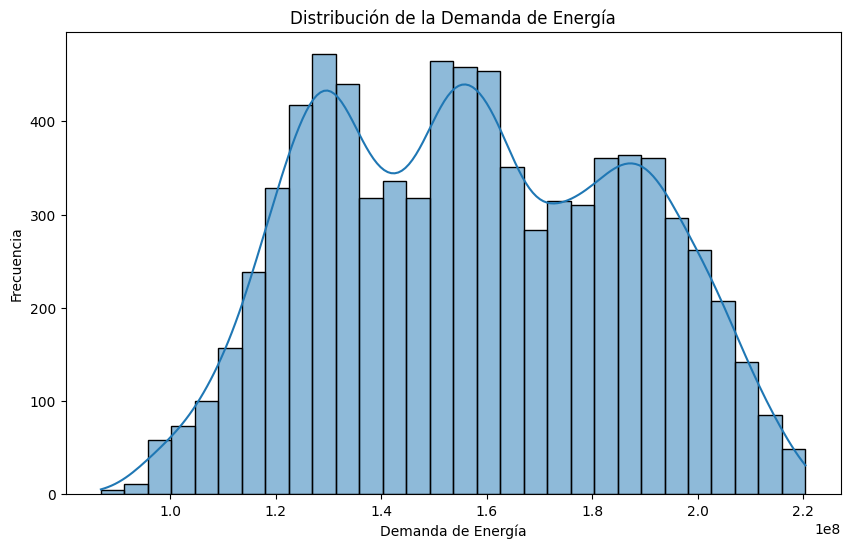

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Demanda Energia SIN kWh'], bins=30, kde=True)
plt.title('Distribución de la Demanda de Energía')
plt.xlabel('Demanda de Energía')
plt.ylabel('Frecuencia')
plt.show()

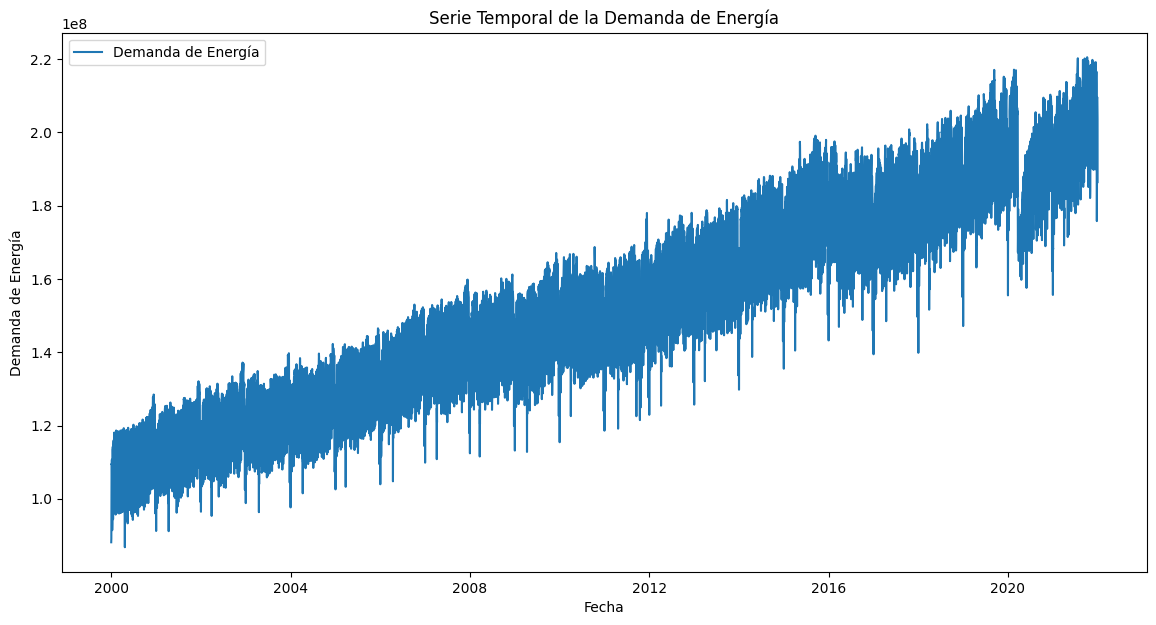

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(df['Fecha'], df['Demanda Energia SIN kWh'], label='Demanda de Energía')
plt.title('Serie Temporal de la Demanda de Energía')
plt.xlabel('Fecha')
plt.ylabel('Demanda de Energía')
plt.legend()
plt.show()

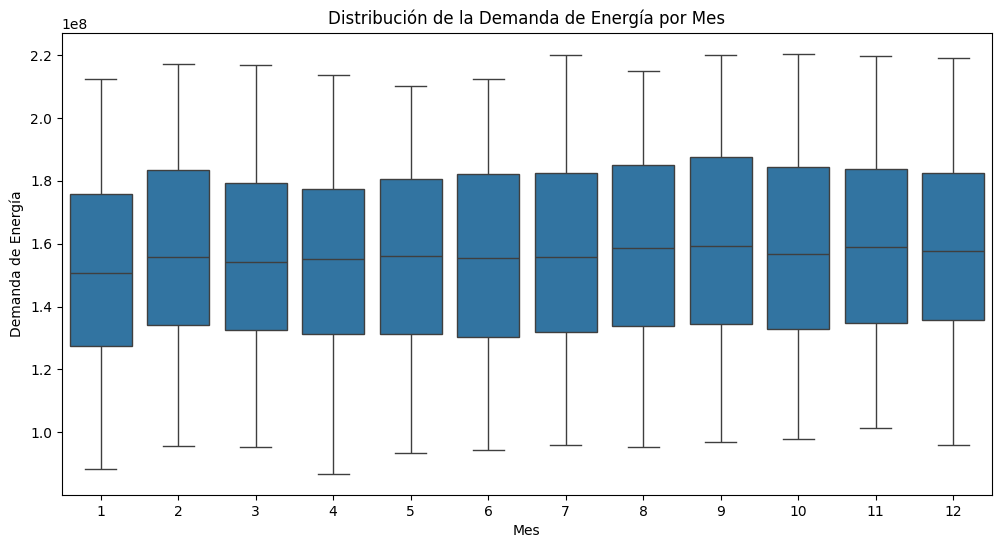

In [9]:
# Extraer el mes y el año
df['month'] = df['Fecha'].dt.month
df['year'] = df['Fecha'].dt.year

# Boxplot por mes
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='Demanda Energia SIN kWh', data=df)
plt.title('Distribución de la Demanda de Energía por Mes')
plt.xlabel('Mes')
plt.ylabel('Demanda de Energía')
plt.show()

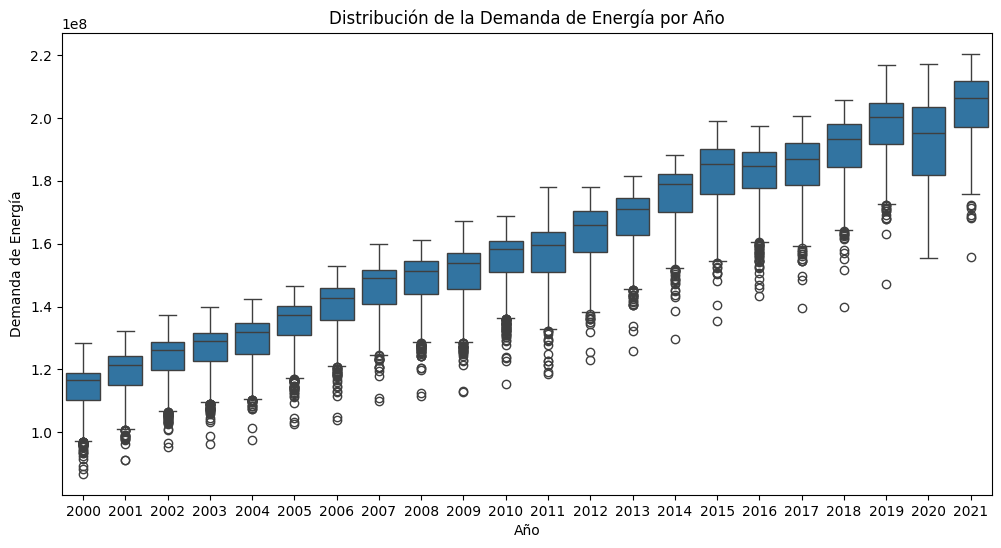

In [10]:
# Boxplot por año
plt.figure(figsize=(12, 6))
sns.boxplot(x='year', y='Demanda Energia SIN kWh', data=df)
plt.title('Distribución de la Demanda de Energía por Año')
plt.xlabel('Año')
plt.ylabel('Demanda de Energía')
plt.show()

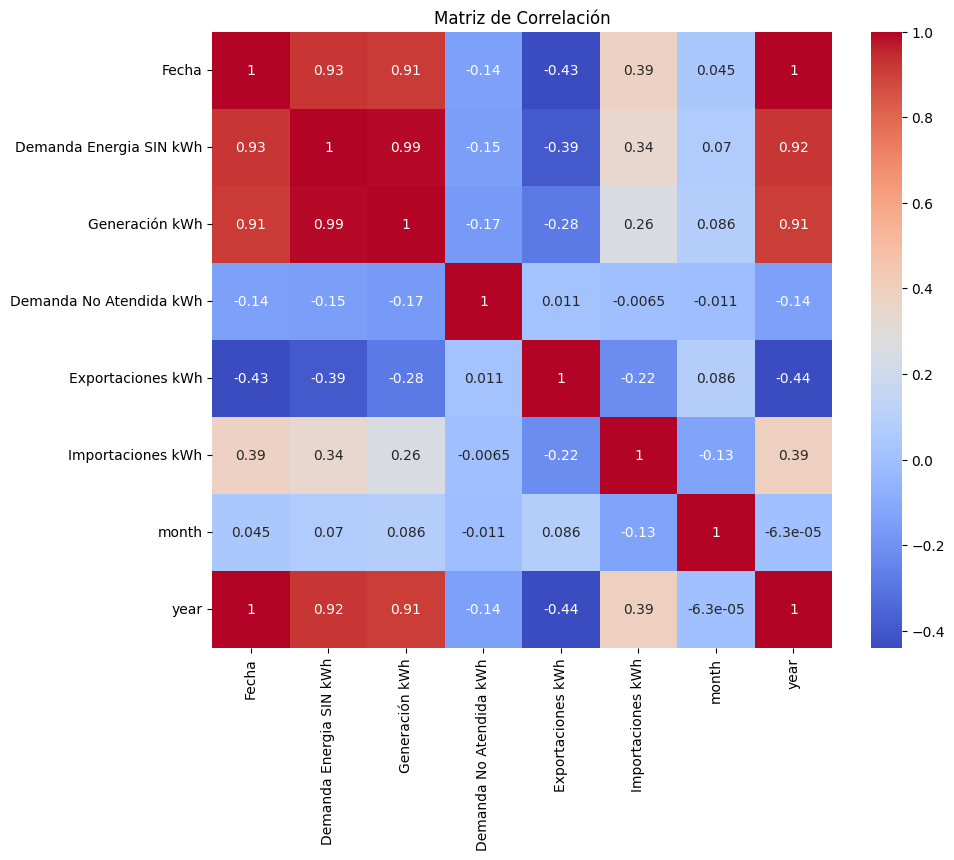

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

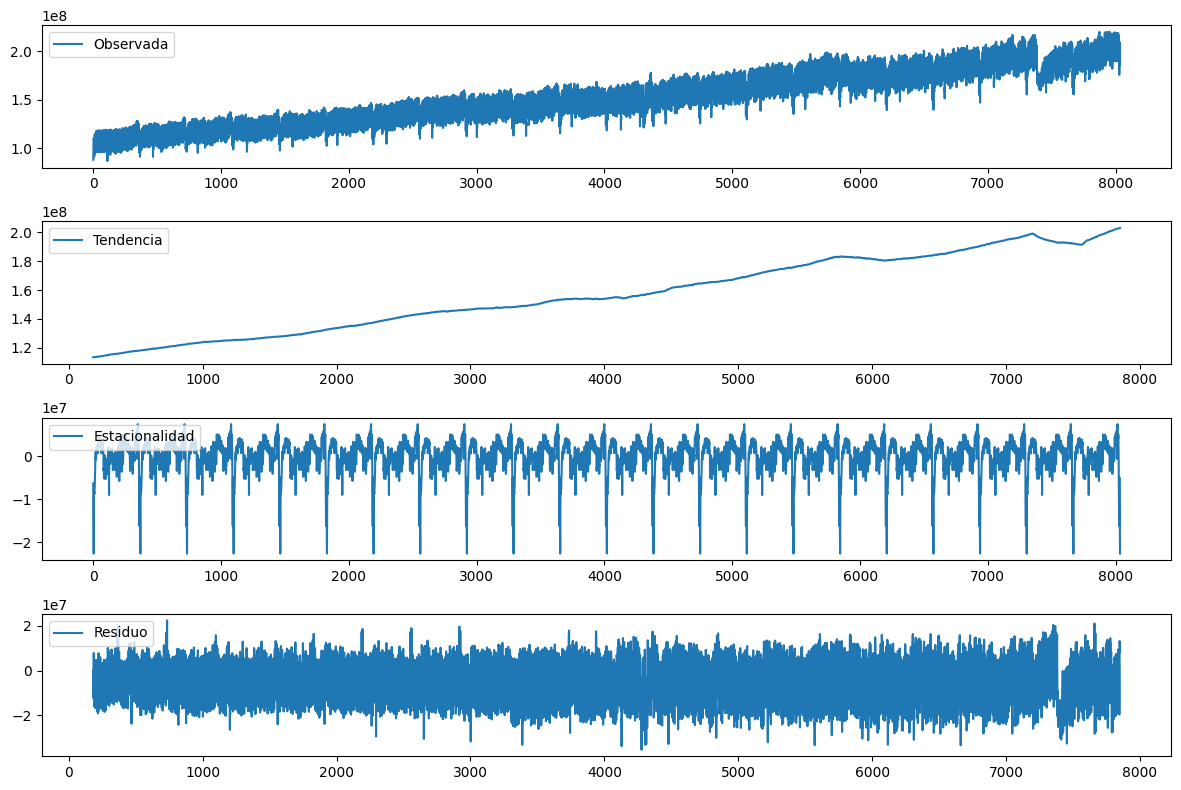

In [12]:
# Descomponer la serie temporal
decomposition = seasonal_decompose(df['Demanda Energia SIN kWh'], model='additive', period=365)

# Visualizar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observada')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

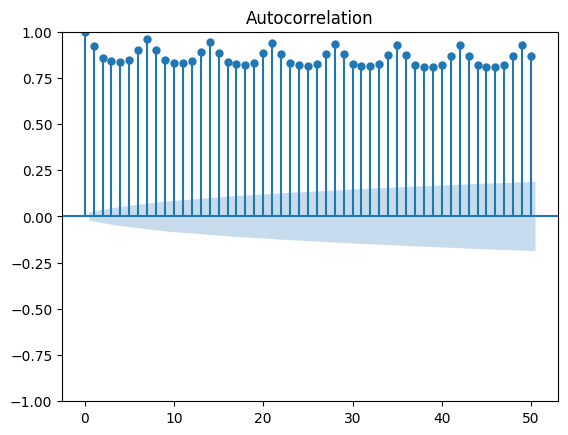

In [13]:
# Autocorrelación (ACF)
plt.figure(figsize=(10, 6))
plot_acf(df['Demanda Energia SIN kWh'].dropna(), lags=50)
plt.show()

<Figure size 1000x600 with 0 Axes>

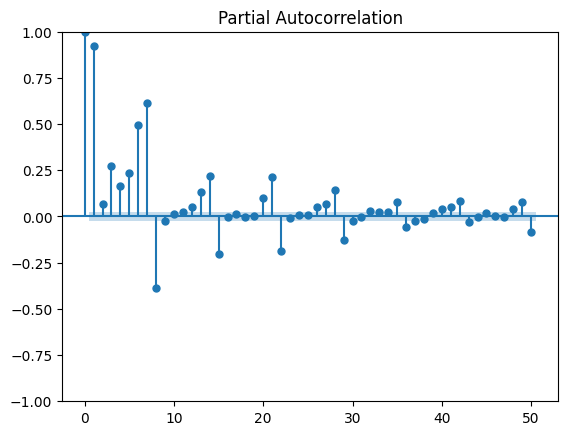

In [14]:
# Autocorrelación parcial (PACF)
plt.figure(figsize=(10, 6))
plot_pacf(df['Demanda Energia SIN kWh'].dropna(), lags=50)
plt.show()

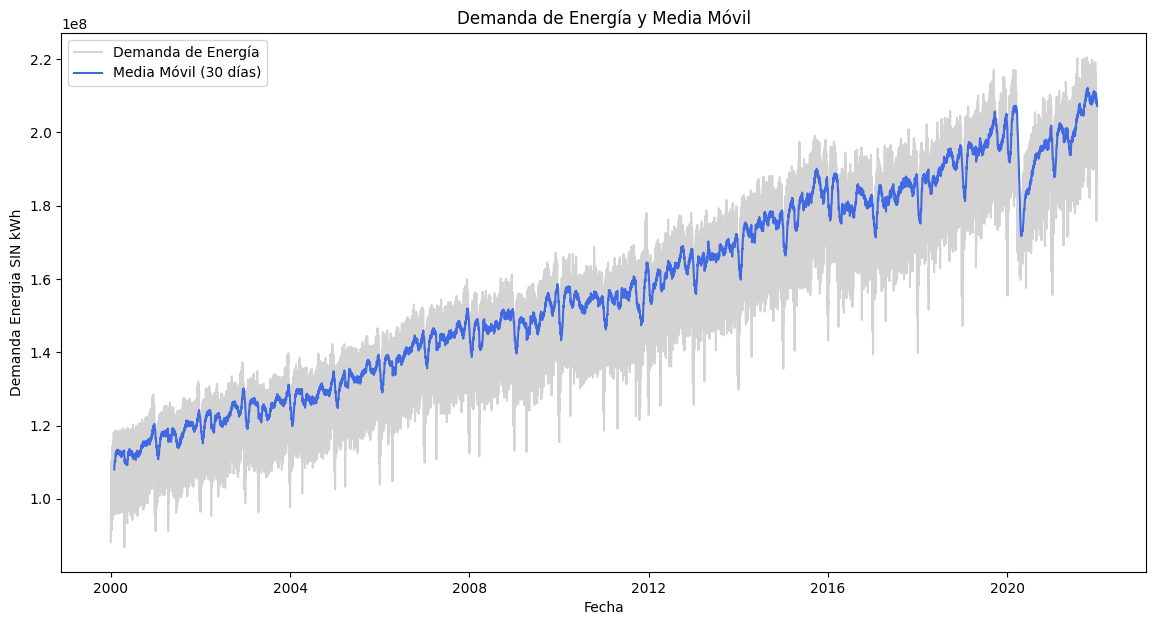

In [33]:
# Media móvil
df['Media_Movil'] = df['Demanda Energia SIN kWh'].rolling(window=30).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['Fecha'], df['Demanda Energia SIN kWh'], label='Demanda de Energía', color='lightgrey')
plt.plot(df['Fecha'], df['Media_Movil'], label='Media Móvil (30 días)', color='royalblue')
plt.title('Demanda de Energía y Media Móvil')
plt.xlabel('Fecha')
plt.ylabel('Demanda Energia SIN kWh')
plt.legend()
plt.show()

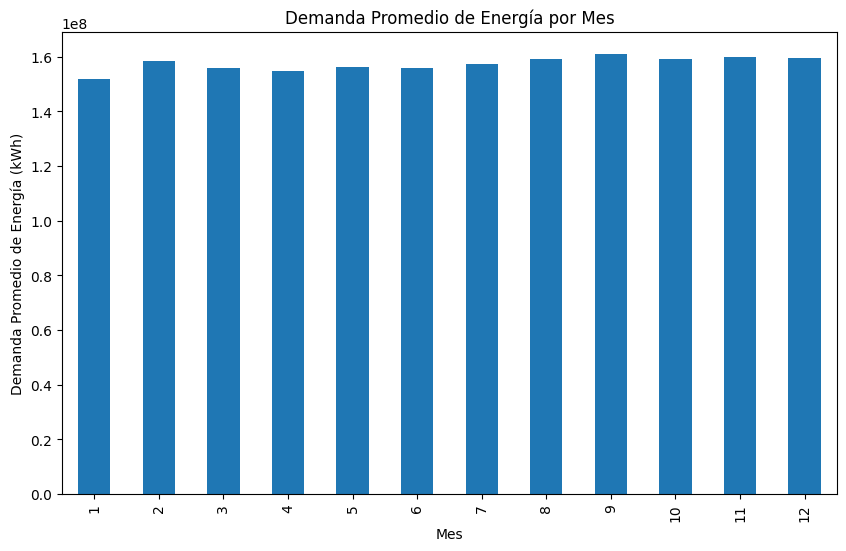

In [16]:
# Demanda promedio por mes
mes_promedio = df.groupby('month')['Demanda Energia SIN kWh'].mean()

plt.figure(figsize=(10, 6))
mes_promedio.plot(kind='bar')
plt.title('Demanda Promedio de Energía por Mes')
plt.xlabel('Mes')
plt.ylabel('Demanda Promedio de Energía (kWh)')
plt.show()

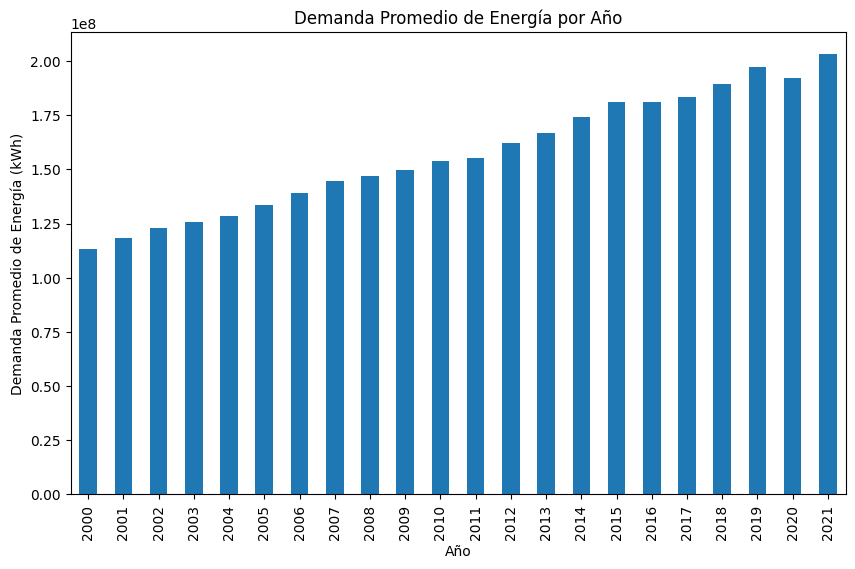

In [17]:
# Demanda promedio por año
año_promedio = df.groupby('year')['Demanda Energia SIN kWh'].mean()

plt.figure(figsize=(10, 6))
año_promedio.plot(kind='bar')
plt.title('Demanda Promedio de Energía por Año')
plt.xlabel('Año')
plt.ylabel('Demanda Promedio de Energía (kWh)')
plt.show()

In [18]:
train_size = int(len(df) * 0.8)
train_data = df['Demanda Energia SIN kWh'][:train_size]
test_data = df['Demanda Energia SIN kWh'][train_size:]

# Reindexar los datos de prueba para que comiencen desde 0
test_data = test_data.reset_index(drop=True)

print(f"Longitud de los datos de entrenamiento: {len(train_data)}")
print(f"Longitud de los datos de prueba: {len(test_data)}")

Longitud de los datos de entrenamiento: 6428
Longitud de los datos de prueba: 1607


In [19]:
# Verificar la longitud de los datos de prueba
print(f"Longitud de los datos de prueba: {len(test_data)}")

# Ajustar sequence_length si es necesario
sequence_length = min(60, len(test_data) - 1)

Longitud de los datos de prueba: 1607


In [20]:
# Crear las secuencias para LSTM
def create_sequences(data, sequence_length):
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i + sequence_length])
        if i + sequence_length < len(data):  # Asegurarnos de no acceder fuera del rango
            y.append(data[i + sequence_length])
    return np.array(x), np.array(y)

In [21]:
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

print(f"x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}")
print(f"x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}")

x_train.shape: (6368, 60, 1), y_train.shape: (6368,)
x_test.shape: (1547, 60, 1), y_test.shape: (1547,)


In [22]:
# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))


c:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
# Entrenar el modelo
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 22568923564081152.0000 - val_loss: 38163778017165312.0000
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 22702314510876672.0000 - val_loss: 38163769427230720.0000
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 22613614846279680.0000 - val_loss: 38163769427230720.0000
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 22566301486546944.0000 - val_loss: 38163769427230720.0000
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 22644652427444224.0000 - val_loss: 38163760837296128.0000
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 22631612906733568.0000 - val_loss: 38163747952394240.0000
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 22527423442583552.0000 - val_loss: 38163747952394240.0000
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 22553751592108032.0000 - val_loss: 38163743657426944.0000
Epoch 9/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/

In [25]:
# Hacer predicciones
predictions = model.predict(x_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [26]:
# Imprimir las primeras predicciones para verificar
print(predictions[:10])

[[214.68683]
 [214.68683]
 [214.68683]
 [214.68683]
 [214.68683]
 [214.68683]
 [214.68683]
 [214.68683]
 [214.68683]
 [214.68683]]
